In [72]:
# using some standard modules here
using Plots          # For Plots
#using DelimitedFiles # For reading text files
using Interpolations # For interpolations
using Polynomials    # Polynomials
using Statistics     # mean, std, etc
using LinearAlgebra  # Linear Algebra 
using NCDatasets     # NetCDF file support
using ForwardDiff
using ImageFiltering
using Interpolations
using SharedArrays
using Distributed
#using Parallel

In [2]:
# Some constants and the planck function (as radiance!)

function planck(wav, T)
    h = 6.626e-34
    c = 299792458.0
    k = 1.38e-23
    c1 = 2.0*h*c^2.0
    c2 = h*c/(wav*k*T)
    intensity = c1/ ( (wav^5.0)*(exp(c2) - 1.0) )
    # Convert to W/sr/m^2/µm here directly (it was W/sr/m^2/m)
    return intensity*1.e-6
end


planck (generic function with 1 method)

In [4]:
# Using the NCDataset tools (note, we used groups and variables while saving)
f = Dataset("files/crossSections_LongTropics.h5");
nu_ = convert(Vector{Float64},f["wavenumberGrid"][:]);

cs_matrix_co2_ = convert(Matrix{Float64},f.group["CrossSections"]["cs_matrix_co2"][:]);
cs_matrix_ch4_ = convert(Matrix{Float64},f.group["CrossSections"]["cs_matrix_ch4"][:]);
cs_matrix_h2o_ = convert(Matrix{Float64},f.group["CrossSections"]["cs_matrix_h2o"][:]);
cs_matrix_o3_ = convert(Matrix{Float64},f.group["CrossSections"]["cs_matrix_o3"][:]);
#cs_matrix_o3_ =convert(Matrix{Float64},f["CrossSections/cs_matrix_o3"][:]);
VCD_dry = convert(Vector{Float64},f.group["Profiles"]["VCD_dry"][:]);
vmr_h2o = convert(Vector{Float64},f.group["Profiles"]["vmr_h2o"][:]);
p_full  = convert(Vector{Float64},f.group["Profiles"]["p"][:]);
T_local = convert(Vector{Float64},f.group["Profiles"]["T_local"][:]);
# Change row column order (ignore for now)
s = size(cs_matrix_co2_)
cs_matrix_co2 = zeros((length(nu_),s[1]))
cs_matrix_ch4 = similar(cs_matrix_co2)
cs_matrix_h2o = similar(cs_matrix_co2)
cs_matrix_o3 = similar(cs_matrix_co2)
for i=1:s[1]
    cs_matrix_co2[:,i]=cs_matrix_co2_[i,:]
    cs_matrix_ch4[:,i]=cs_matrix_ch4_[i,:]
    cs_matrix_h2o[:,i]=cs_matrix_h2o_[i,:]
    cs_matrix_o3[:,i]=cs_matrix_o3_[i,:]
end


In [5]:
mutable struct fitSetup
    cs_matrix_h2o::Matrix{Float64} 
    cs_matrix_co2::Matrix{Float64}
    cs_matrix_ch4::Matrix{Float64} 
    nu_in::Vector{Float64} 
    VCD_dry::Vector{Float64}
    T_local::Vector{Float64}
    n_layers::Int
    μ::Float64
    tau_co2::Matrix{Float64} 
    tau_ch4::Matrix{Float64} 
    tau_h2o::Matrix{Float64}
    tau::Matrix{Float64}
    T::Matrix{Float64}
    TT::Matrix{Float64}
    R::SharedArray{Float64}
end
fs = fitSetup(cs_matrix_h2o,cs_matrix_co2,cs_matrix_ch4,nu_,VCD_dry,T_local, s[1], 1.0,similar(cs_matrix_h2o),similar(cs_matrix_h2o),similar(cs_matrix_h2o),similar(cs_matrix_h2o),similar(cs_matrix_h2o),similar(cs_matrix_h2o) ,similar(cs_matrix_h2o) );

In [6]:
NLEV = s[1]

72

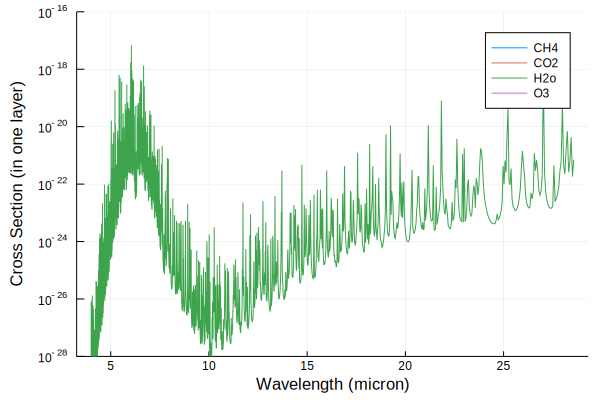

In [7]:
gr()
sp = 40
wo = 40
plot(1e4./nu_[1:sp:end], cs_matrix_ch4[1:sp:end,wo], yaxis=:log, label="CH4")
plot!(1e4./nu_[1:sp:end], cs_matrix_co2[1:sp:end,wo], yaxis=:log, label="CO2")
plot!(1e4./nu_[1:sp:end], cs_matrix_h2o[1:sp:end,wo], yaxis=:log, label="H2o")
plot!(1e4./nu_[1:sp:end], cs_matrix_o3[1:sp:end,wo], yaxis=:log, label="O3")
ylims!((1e-28,1e-16))
xlabel!("Wavelength (micron)")
ylabel!("Cross Section (in one layer)")

In [8]:
n_layers=72
xa = zeros(72*3+1)
xa[1:n_layers].=400e-6              # CO2
xa[1+n_layers:2n_layers].=1800e-9   # CH4
xa[1+2n_layers:3n_layers]= vmr_h2o;  # H2O
# Skin temperature:
xa[end]=300

300

In [97]:
# Simples forward model here 
function Thermal_up(x; p::fitSetup=fs)
    wl_nu = 1.e7./p.nu_in*1.e-9
    
    # Generate matrices of optical thickness per layer now for each gas: 
    tau_co2 = (p.cs_matrix_co2.*p.VCD_dry').*x[1:p.n_layers]'.*1/p.μ;
    tau_h2o = (p.cs_matrix_h2o.*p.VCD_dry').*x[1+2p.n_layers:3p.n_layers]'.*1/p.μ;
    tau_ch4 = (p.cs_matrix_ch4.*p.VCD_dry').*x[1+p.n_layers:2p.n_layers]'*1/p.μ;
    tau = tau_co2.+tau_h2o.+tau_ch4
    
    # Transmission of each layer:
    T = exp.(-tau)
    
    # Surface emissions:
    B_surf = planck.(wl_nu,x[end])

    R = similar(T)#SharedArray{Float64}(size(T)) @distributed 
    for i = 1:p.n_layers
        R[:,i] = planck.(wl_nu,T_local[i]).*(1 .-T[:,i]).*prod(T[:,1:i-1],dims=2)
    end
    #Rs = convert(Array,R)
    #println(typeof(Rs))
    return B_surf.*prod(T,dims=2)+sum(R,dims=2)
    
    
end

Thermal_up (generic function with 1 method)

In [99]:
@time B = Thermal_up(xa);

  1.513784 seconds (1.78 k allocations: 2.860 GiB, 43.13% gc time)


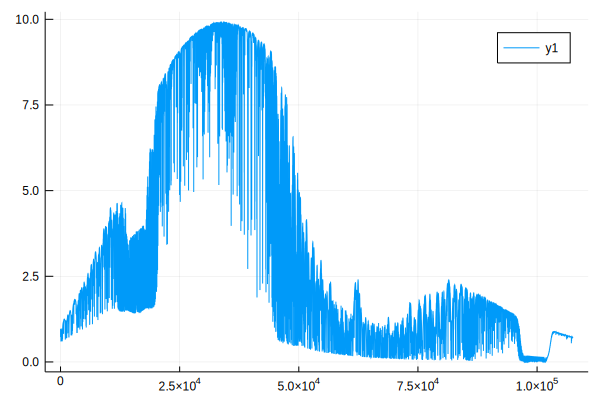

In [100]:
plot(B)

In [102]:
g = x -> ForwardDiff.jacobian(Thermal_up, x);

In [103]:
@time K = g(xa);

388.856209 seconds (6.99 M allocations: 706.597 GiB, 14.40% gc time)


In [104]:
K_co2 = K[:,1:72]./fs.VCD_dry'

107501×72 Array{Float64,2}:
  0.0           0.0           0.0          …   0.0           0.0        
  0.0           0.0           0.0              0.0           0.0        
  0.0           0.0           0.0              0.0           0.0        
  0.0           0.0           0.0              0.0           0.0        
  0.0           0.0           0.0              0.0           0.0        
  0.0           0.0           0.0          …   0.0           0.0        
  0.0           0.0           0.0              0.0           0.0        
  0.0           0.0           0.0              0.0           0.0        
  0.0           0.0           0.0              0.0           0.0        
  0.0           0.0           0.0              0.0           0.0        
  0.0           0.0           0.0          …   0.0           0.0        
  0.0           0.0           0.0              0.0           0.0        
  0.0           0.0           0.0              0.0           0.0        
  ⋮                    

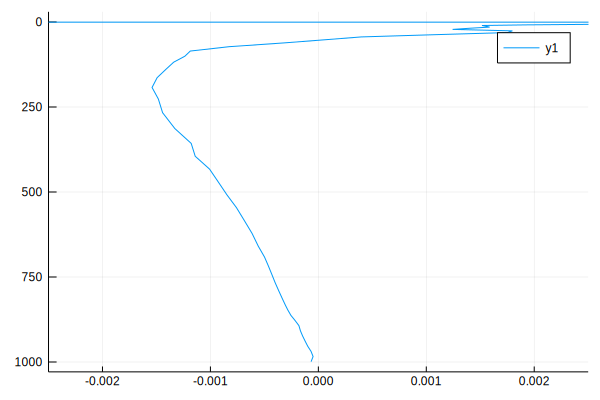

In [124]:
plot(1e15* sum(K[:,1:72],dims=1)'./fs.VCD_dry, p_full, yaxis=:invert)
xlims!((-0.0025,0.0025))
#ylims!(-0.1,0.1)

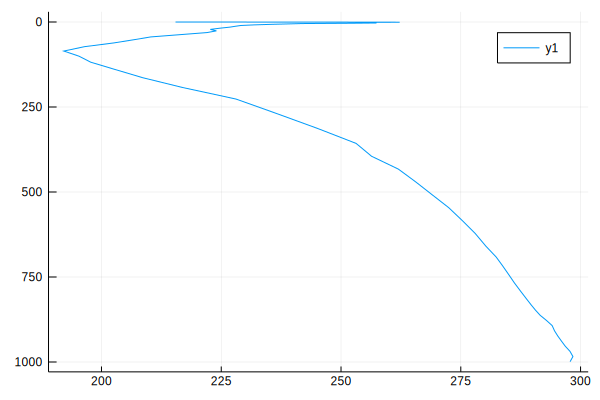

In [112]:
plot( T_local, p_full, yaxis=:invert)

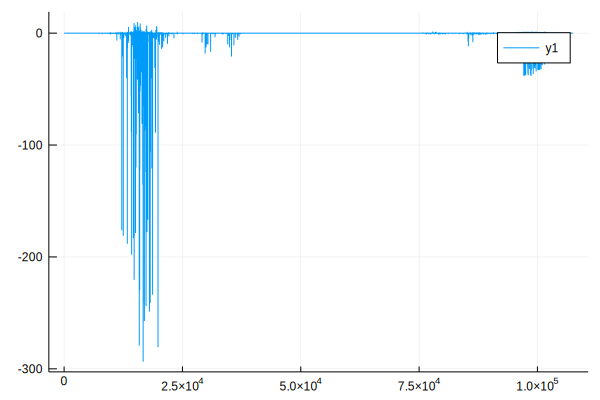

In [106]:
plot(K[:,10])